# Map Leiden Clusters to Tentative Cell-Types

This analysis trims the gene lists of both the scRNAseq and Merfish datasets to the genes that they have in common. The dimensionality of the trimmed gene list is further reduced by principal components analysis (PCA), mapping the cell types of the scRNAseq taxonomy to a compact, shared gene expression space. The normalized gene expression of each Leiden cluster derived from the Merfish experiment is mapped into this PCA space, and the closest match between Merfish cluster and scRNAseq taxonomic group is found using cosine distance.

By mapping the list of cells to a higher-order biological entity (taxonomic group/cluster), differences in data collection efficiency and experimental noise are reduced and the underlying gene/cell type information is exposed and can be compared between expriments. These higher-order entities can then be mapped back to individual cells, producing a cell-type annotated spatial maps. 

## Required initialization

In [10]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy
from observable_jupyter import embed
from math import cos, sin

## Load data

In [11]:
import loompy
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial import distance
import seaborn as sns
import matplotlib.pyplot as plt

with loompy.connect('l5_all.agg.loom') as ds:
    expr = ds[:,:]
    genes = ds.ra.Gene
    clusters = ds.ca.ClusterName
    clust_desc = ds.ca.TaxonomyRank4

# Trim data to genes that are shared by the data sources
sig_leiden = pd.read_csv('merfish_sig_leiden.csv', index_col=0)

gene_match = [g in sig_leiden.index.to_list() for g in genes]
seq_by_clust = pd.DataFrame(expr[gene_match,:], index = genes[gene_match], columns = clusters)
trimmed_merfish = sig_leiden.loc[[m in genes[gene_match] for m in sig_leiden.index]]

In [16]:
# expr0 = pd.DataFrame(expr, index=genes, columns=clusters)
# sig_leiden0 = sig_leiden.loc[sig_leiden.index.isin(expr0.index), :]
# expr0 = expr0.loc[sig_leiden0.index]


## Fit PCA to scRNAseq and MERFISH data

In [17]:

# Fit PCA to scRNAseq Data
x = seq_by_clust.sort_index().T.values
x = StandardScaler().fit_transform(x)

pca = PCA(0.6)
pca.fit(x)
principalComponents = pca.transform(x)
scRNAseq_pca = pd.DataFrame(
    data = principalComponents,
    columns=["PC_" + str(num + 1) for num in range(len(principalComponents[0]))]
)
scRNAseq_pca.index = seq_by_clust.sort_index().T.index
scRNAseq_pca = scRNAseq_pca.T

# Apply PCA to merfish data
x = trimmed_merfish.sort_index().T.values
x = StandardScaler().fit_transform(x)

principalComponents = pca.transform(x)
merfish_pca = pd.DataFrame(
    data = principalComponents,
    columns=["PC_" + str(num + 1) for num in range(len(principalComponents[0]))]
)
merfish_pca.index = trimmed_merfish.sort_index().T.index
merfish_pca = merfish_pca.T

## Find minimum distance pairs in PCA space 

In [18]:
# Find minimum distance pairs in PCA space (not optimized for performance)
dist_array = []
for merfish_cluster in merfish_pca.columns:
    min_distance = {
        "merfish_cluster": merfish_cluster,
        "scRNAseq_cluster": "NA",
        "distance": 100
    }
    for scRNAseq_cluster in scRNAseq_pca.columns:
        dist = distance.cosine(
            merfish_pca[merfish_cluster].to_list(), 
            scRNAseq_pca[scRNAseq_cluster].to_list(), 
        )
        if dist < min_distance.get("distance"):
            min_distance["scRNAseq_cluster"] = scRNAseq_cluster
            min_distance["distance"] = dist
    dist_array.append(min_distance)
    
# Join data into output table
mapped_PCA_COS_clusters = pd.DataFrame(dist_array).join(
    pd.DataFrame(clust_desc, index = clusters, columns = ["Description"]), on='scRNAseq_cluster'
)

# super_table = meta_leiden.merge(mapped_PCA_COS_clusters, left_on='leiden', right_on='merfish_cluster')
# meta_leiden = super_table[['cell counts','leiden', 'Description']]
# meta_leiden.index = meta_leiden['leiden']

In [19]:
meta_cluster = mapped_PCA_COS_clusters.set_index('merfish_cluster')
meta_cluster.index.name = None
meta_leiden['Description'] = meta_cluster['Description']

In [30]:
merfish_pca

,Leiden-0,Leiden-1,Leiden-2,Leiden-3,Leiden-4,Leiden-5,Leiden-6,Leiden-7,Leiden-8,Leiden-9,...,Leiden-21,Leiden-22,Leiden-23,Leiden-24,Leiden-25,Leiden-26,Leiden-27,Leiden-28,Leiden-29,Leiden-30
PC_1,-7.581742,8.421115,-12.104160,-6.998290,6.369287,5.954640,-4.619192,5.663410,6.405269,6.571165,...,-0.510593,3.989153,-7.807297,-9.852088,3.904232,0.162406,-8.519246,6.448011,0.184757,5.942116
PC_2,-2.352379,2.407643,5.169007,-3.867943,-2.797807,-0.438073,-3.601685,-1.597246,-2.173132,-1.089385,...,-3.228099,2.924412,3.863765,0.473679,0.055023,-3.530951,7.218928,-1.504752,0.650293,-0.671705
PC_3,-0.673699,-4.585444,7.889976,-3.068728,2.453064,-0.500771,-2.132465,-0.584920,1.517236,1.984444,...,0.247892,-4.007526,-4.387360,1.967931,-1.679595,-0.389811,-0.857518,-0.030276,4.915773,-0.109825
PC_4,-5.347989,-0.610703,0.984594,-5.873297,1.930922,0.946467,-5.034920,-0.008415,1.670810,2.022796,...,-1.995247,-1.236223,-6.091680,-3.356083,-0.738337,-2.672032,-3.918165,1.474400,1.798050,1.085311
PC_5,-4.216612,5.141264,4.286086,-4.617212,-0.657992,1.476782,-3.390035,1.726151,-0.179022,-0.071097,...,-1.358014,2.726227,-4.645614,-1.225245,1.020568,-1.515472,-2.665676,1.137950,1.566570,0.407106
PC_6,-6.534155,0.482447,0.440140,-1.709261,1.417425,-1.555176,-2.626370,1.181856,2.628887,2.428736,...,-2.240488,-0.141498,-4.219449,-1.460703,0.315263,-2.107602,-5.093683,1.089308,2.376751,2.489443
PC_7,1.518980,-3.344572,-1.569923,-8.863508,2.042740,-0.074657,-5.724190,0.318584,3.423996,2.919334,...,1.379656,-1.392510,2.883095,-6.692149,-1.518030,-3.343412,2.379084,0.794331,1.351920,0.810771
PC_8,-1.435764,0.563246,1.368470,2.224826,-0.013310,-1.489836,1.067760,-0.041425,0.604976,-0.033043,...,0.018541,-0.497266,-3.982916,1.763983,-1.148660,0.303585,-0.150728,0.417679,1.270606,1.012587
PC_9,-5.795240,-5.394675,-0.320118,6.575817,2.187317,-2.732576,2.735950,-2.769953,2.780262,2.855815,...,-2.803260,-3.753778,-2.569299,4.534122,-1.739096,1.110841,-1.739516,0.143813,2.186236,-1.179774
PC_10,-9.928540,2.044810,-2.783275,2.895781,0.029052,1.677532,-0.033202,2.278824,-0.323079,0.307491,...,-5.016344,0.882397,-6.784736,0.147783,0.961711,1.998336,1.192000,0.075568,-0.570585,1.256551


In [22]:
from sklearn.metrics import pairwise_distances
dist = pairwise_distances(merfish_pca.T, scRNAseq_pca.T, 'cosine')
dist

array([[1.17575128, 1.20897823, 1.19846471, ..., 1.08462859, 1.0170322 ,
        1.08977276],
       [0.77439384, 0.5774035 , 0.69230106, ..., 0.8196093 , 0.87370638,
        0.84370859],
       [1.12331525, 1.21058393, 1.20098275, ..., 0.97438284, 0.93405249,
        1.00843023],
       ...,
       [0.81166711, 0.8328285 , 0.92624182, ..., 1.03357553, 1.00528642,
        0.97878531],
       [0.93209547, 1.07021271, 1.14717887, ..., 1.10406012, 1.06728246,
        0.97876535],
       [0.8142468 , 0.34315875, 0.85803753, ..., 1.02117785, 1.13968683,
        0.98312068]])

In [23]:
dist = pd.DataFrame(dist, merfish_pca.columns, scRNAseq_pca.columns)
dist

,ENT9,ENT8,ENT6,ENT5,ENT4,ENT7,ENT3,ENT2,ENT1,ENTG1,...,PSPEP8,PSNF2,PSNF3,PSNF1,PSNP1,PSNP3,PSNP2,PSNP5,PSNP4,PSNP6
Leiden-0,1.175751,1.208978,1.198465,1.090185,0.953396,1.082165,1.064875,1.134994,1.145969,0.876712,...,0.977868,1.033861,1.079930,1.019383,1.031180,1.049974,1.071969,1.084629,1.017032,1.089773
Leiden-1,0.774394,0.577403,0.692301,0.883921,1.068078,0.822763,0.946879,0.852962,0.790378,1.256827,...,0.977738,0.881972,0.856427,0.854640,0.847814,0.837327,0.830161,0.819609,0.873706,0.843709
Leiden-2,1.123315,1.210584,1.200983,1.072418,0.992929,1.090511,1.106958,1.169360,1.159071,0.888281,...,0.959837,1.054896,1.067395,1.088575,1.046577,1.023502,1.039708,0.974383,0.934052,1.008430
Leiden-3,1.174668,1.270543,1.117040,1.006894,0.859312,1.075876,0.957772,1.039509,1.054249,0.820329,...,1.006561,1.087824,1.102343,1.155434,1.132826,1.084489,1.069879,1.107162,1.107033,1.117372
Leiden-4,0.959895,1.002799,1.026410,1.117616,1.232733,1.049905,1.069749,1.022280,0.974150,1.170741,...,1.257351,1.154898,1.057646,1.071053,1.212356,1.179655,1.159778,1.150705,1.080507,1.042983
Leiden-5,1.005447,1.018452,0.916438,1.003517,1.139627,1.048021,1.023719,0.890089,1.088432,1.222938,...,1.020029,0.747295,0.830789,0.807562,0.924178,0.897145,0.904132,1.038827,0.993399,0.980591
Leiden-6,1.242717,1.308266,1.171620,1.073977,0.915185,1.111279,1.012372,1.098970,1.112907,0.842469,...,1.022675,1.087218,1.112766,1.120440,1.122898,1.089805,1.083983,1.158802,1.126324,1.132871
Leiden-7,0.985595,0.856787,0.851278,0.841583,1.073918,1.008260,0.879627,0.797298,0.901779,1.265583,...,1.054195,0.981498,1.040531,1.004134,0.985329,1.007829,1.058746,0.989545,0.980739,0.935527
Leiden-8,0.807499,0.944816,0.945147,1.081335,1.220095,1.002650,1.065683,1.037190,0.986213,1.159380,...,1.222063,1.188858,1.089830,1.061264,1.118431,0.982926,0.979055,1.076273,1.040350,0.932512
Leiden-9,0.876740,0.673117,0.840928,1.035317,1.165503,0.863678,0.968129,0.915852,0.804287,1.178956,...,1.140846,1.165090,1.039051,1.030843,1.035817,0.978009,0.952577,0.950785,0.966719,1.031789


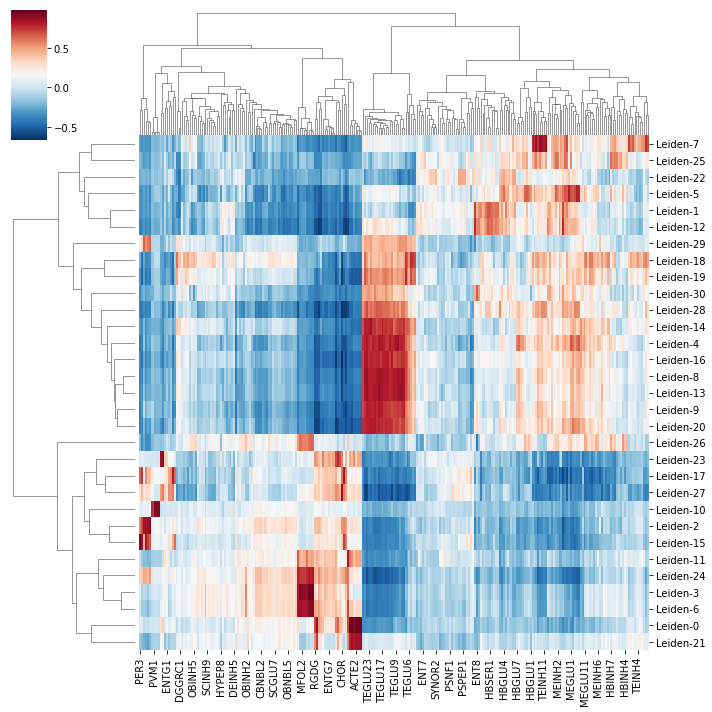

In [24]:
from seaborn import clustermap
cg = clustermap(1-dist, cmap='RdBu_r')

## Correlation plot

In [25]:
meta_leiden = pd.read_csv('merfish_meta_leiden.csv', index_col=0)
# meta_cluster = mapped_PCA_COS_clusters.set_index('merfish_cluster')
# meta_cluster.index.name = None
# meta_leiden['Description'] = meta_cluster['Description']

In [26]:
output = mapped_PCA_COS_clusters.pivot(index='merfish_cluster',columns='scRNAseq_cluster',values='distance').fillna(0)

In [27]:
idx = np.arange(output.shape[1])
idx = (output>0).dot(idx[:,None])
idx = np.argsort(idx[0])

<AxesSubplot:xlabel='scRNAseq_cluster', ylabel='merfish_cluster'>

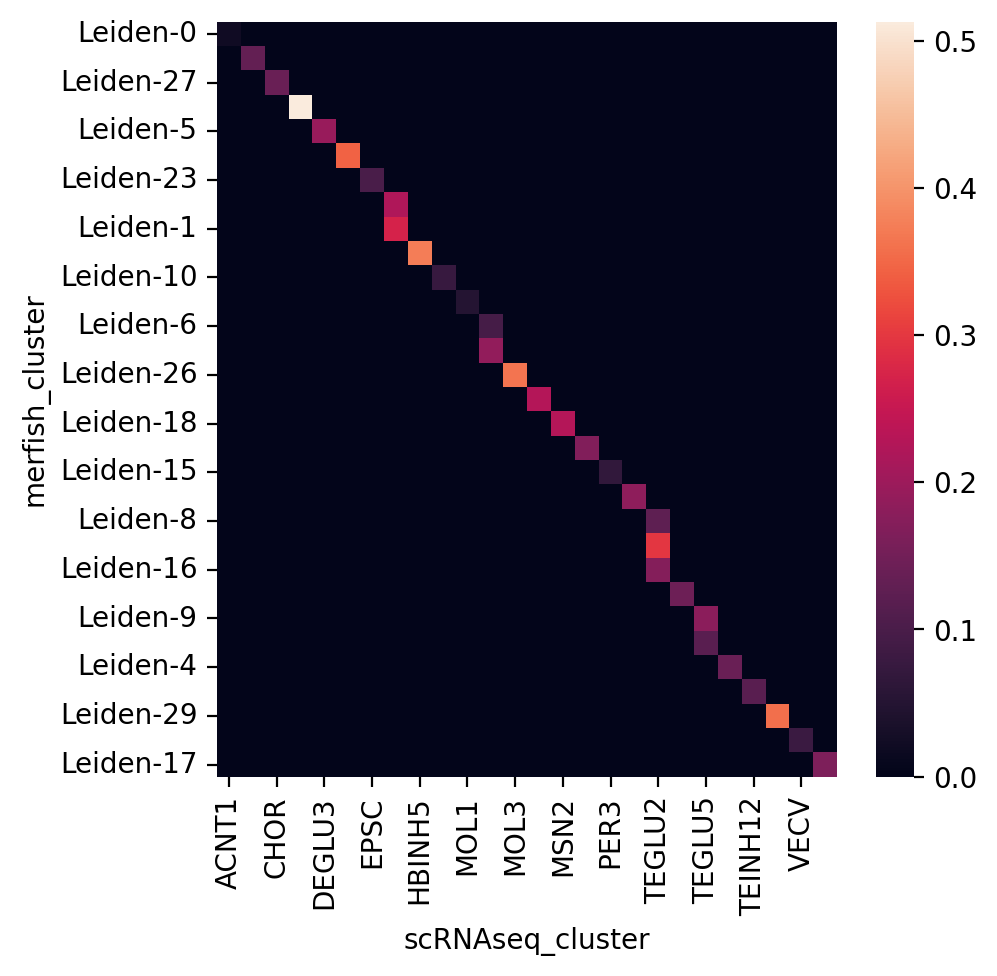

In [28]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=200, ncols=1)
#ratio = mapped_PCA_COS_clusters['distance']
#output.sort_index(level=0, ascending=True, inplace=True)
sns.heatmap(output.iloc[idx.values], ax=ax)

In [29]:
sig_leiden

,Leiden-0,Leiden-1,Leiden-2,Leiden-3,Leiden-4,Leiden-5,Leiden-6,Leiden-7,Leiden-8,Leiden-9,...,Leiden-21,Leiden-22,Leiden-23,Leiden-24,Leiden-25,Leiden-26,Leiden-27,Leiden-28,Leiden-29,Leiden-30
Oxgr1,-0.065320,0.064790,-0.060039,-0.066187,-0.022510,-0.069012,-0.064519,-0.051604,-0.013655,0.099101,...,-0.072674,-0.047576,1.398580,-0.097314,-0.100191,-0.076897,-0.109813,-0.072714,-0.047067,-0.088333
Htr1a,-0.215109,0.270296,-0.216059,-0.267977,0.087681,-0.250823,-0.190161,0.381995,0.342836,0.142504,...,0.048389,-0.213985,-0.244917,-0.273035,-0.221343,-0.279173,-0.255329,-0.090457,0.056592,1.017588
Htr1b,-0.298763,0.533263,-0.290322,-0.334947,-0.100624,-0.212598,-0.206724,-0.109621,0.038506,-0.101510,...,-0.045048,-0.095361,-0.331365,-0.334978,-0.322644,-0.305956,-0.345324,-0.290537,-0.095835,-0.157035
Htr1d,-0.120172,0.258783,-0.138198,-0.157549,-0.164425,-0.105607,-0.129773,0.070433,-0.155550,-0.156395,...,-0.044470,-0.131803,-0.144665,-0.174238,-0.123334,-0.152621,-0.154171,0.062296,-0.168702,-0.174237
Htr1f,-0.332587,0.043992,-0.334967,-0.345461,0.389668,-0.202123,-0.271488,0.242541,0.730359,-0.304587,...,-0.007840,-0.298530,-0.314910,-0.357772,-0.345184,-0.292470,-0.368544,0.298010,0.134642,-0.368543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ros1,-0.039147,-0.025990,-0.034438,-0.057621,0.023417,0.009962,-0.054977,-0.017528,0.032779,0.056025,...,-0.024251,-0.037521,-0.053769,-0.050659,-0.047514,0.024983,-0.044145,0.003779,0.058436,-0.065246
Ryk,0.171613,-0.158053,-0.211436,0.739100,-0.084286,-0.386930,0.306794,-0.110844,-0.318694,0.084276,...,-0.165211,-0.176834,0.182692,0.257514,-0.247224,-0.211322,0.577096,-0.137375,-0.239867,-0.219181
Tek,-0.275000,-0.280188,2.507936,-0.286880,-0.285571,-0.251118,-0.280323,-0.272438,-0.282730,-0.290088,...,-0.263971,-0.254993,-0.277321,0.936582,-0.206817,-0.278711,-0.175911,-0.277515,0.895431,-0.272865
Tie1,-0.259167,-0.257257,2.333781,-0.263667,-0.247908,-0.240093,-0.257949,-0.261929,-0.246301,-0.253383,...,-0.239000,-0.231360,-0.278619,0.725350,-0.193093,-0.264989,0.045624,-0.250315,0.594653,-0.270383


In [81]:
output

scRNAseq_cluster,Astrocytes-ACNT1,Astrocytes-ACNT2,Cholinergic and monoaminergic neurons-DECHO1,Cholinergic and monoaminergic neurons-HBADR,Choroid epithelial cells-CHOR,Di- and mesencephalon excitatory neurons-DEGLU3,Di- and mesencephalon inhibitory neurons-HBINH5,Enteric neurons-ENT8,Ependymal cells-EPSC,Microglia-MGL3,...,Telencephalon projecting excitatory neurons-TEGLU2,Telencephalon projecting excitatory neurons-TEGLU24,Telencephalon projecting excitatory neurons-TEGLU5,Telencephalon projecting excitatory neurons-TEGLU8,Telencephalon projecting inhibitory neurons-MSN1,Telencephalon projecting inhibitory neurons-MSN2,Vascular and leptomeningeal cells-VLMC1,Vascular endothelial cells-VECC,Vascular endothelial cells-VECV,Vascular smooth muscle cells-PER3
merfish_cluster,,,,,,,,,,,,,,,,,,,,,
Leiden-0,0.020439,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Leiden-1,0.000000,0.000000,0.000000,0.270546,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Leiden-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.075603,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Leiden-11,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Leiden-12,0.000000,0.000000,0.000000,0.221974,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Leiden-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.00000,0.118209,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Leiden-14,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.14276,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Leiden-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.067781
Leiden-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.171857,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


In [20]:
mapped_PCA_COS_clusters

,merfish_cluster,scRNAseq_cluster,distance,Description
0,Leiden-0,ACNT1,0.020439,Astrocytes
1,Leiden-1,HBADR,0.270546,Cholinergic and monoaminergic neurons
2,Leiden-2,VECV,0.079359,Vascular endothelial cells
3,Leiden-3,MOL1,0.048439,Oligodendrocytes
4,Leiden-4,TEGLU8,0.139854,Telencephalon projecting excitatory neurons
5,Leiden-5,DEGLU3,0.194950,Di- and mesencephalon excitatory neurons
6,Leiden-6,MOL2,0.093751,Oligodendrocytes
7,Leiden-7,TEINH12,0.119142,Telencephalon inhibitory interneurons
8,Leiden-8,TEGLU2,0.126159,Telencephalon projecting excitatory neurons
9,Leiden-9,TEGLU5,0.179933,Telencephalon projecting excitatory neurons


In [15]:
df = pd.read_csv('clusters.csv', index_col=0)

In [16]:
df['leiden'].nunique()

31

## Hierarchically Cluster Leiden Gene Expression Data

In [36]:
from clustergrammer2 import net, Network, CGM2
import anndata

In [28]:
cell_by_gene = pd.read_csv('~/vizgen/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate1_cell_by_gene_S2R1.csv', index_col=0)
meta_gene = pd.DataFrame(index=cell_by_gene.columns.tolist())
meta_gene['expression'] = cell_by_gene.sum(axis=0)

In [37]:
ad_viz = anndata.read_h5ad('ad_viz.adata')

In [29]:
meta_gene['info'] = pd.Series('', index=meta_gene.index.tolist())
glial_markers = ['Aqp4', 'Slc25a18', 'Mlc1', 'Gfap']
meta_gene.loc[glial_markers, 'info'] = 'Glial markers'

gabaergic_genes = ['Gad1', 'Slc32a1']
meta_gene.loc[gabaergic_genes, 'info'] = 'GABAergic markers'

df_colors = pd.read_csv('df_colors.csv')
df_colors.loc[''] = 'white'


In [30]:
net = Network(CGM2)
# net.load_df(sig_leiden, meta_col=meta_leiden, col_cats=['cell counts'])
net.load_df(sig_leiden, meta_col=meta_leiden, col_cats=['leiden', 'Description', 'cell counts'], 
            meta_row=meta_gene, row_cats=['info', 'expression'])
net.filter_threshold(0.01, axis='row')
net.normalize(axis='row', norm_type='zscore')
net.set_global_cat_colors(df_colors)
net.cluster()

In [46]:
import zlib, json, base64
def json_zip(j):
    zip_json_string = base64.b64encode(
        zlib.compress(
            json.dumps(j).encode('utf-8')
        )
    ).decode('ascii')
    return zip_json_string

In [47]:
%%capture
# Collect data for interactive visualization
################################################

cell_by_gene.index = range(len(cell_by_gene.index.tolist()))
gex_int = cell_by_gene.astype(np.int)

gex_dict = {}
for inst_gene in gex_int.columns.tolist():
    if 'Blank' not in inst_gene:
        ser_gene = gex_int[inst_gene]
        ser_gene = ser_gene[ser_gene > 0]
        ser_gene = ser_gene.astype(np.int8)    
        gex_dict[inst_gene] = ser_gene.to_dict()


df_pos = ad_viz.obs[['center_x', 'center_y', 'leiden']]
df_pos[['center_x', 'center_y']] = df_pos[['center_x', 'center_y']].round(2)
df_pos.columns = ['x', 'y', 'leiden']
df_pos['y'] = -df_pos['y']
df_umap = ad_viz.obsm.to_df()[['X_umap1', 'X_umap2']].round(2)
df_umap.columns = ['umap-x', 'umap-y']

# rotate the mouse brain to the upright position
theta = np.deg2rad(-15)
rot = np.array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])    
df_pos[['x', 'y']] = df_pos[['x', 'y']].dot(rot)

df_name = pd.DataFrame(df_pos.index.tolist(), index=df_pos.index.tolist(), columns=['name'])

df_obs = pd.concat([df_name, df_pos, df_umap], axis=1)
data = df_obs.to_dict('records')

obs_data = {
    'gex_dict': gex_dict,
    'data': data, 
    'cat_colors': cat_colors,
    'network': net.viz    
}

zip_obs_data = json_zip(obs_data)

inputs = {
    'zoom': -3.5, 
    'ini_cat': 'leiden',
    'ini_map_type': 'Spatial',
    'ini_min_radius': 1.75,
    'zip_obs_data': zip_obs_data,
    'gex_opacity_contrast_scale': 0.85
}

In [ ]:
embed('@vizgen/umap-spatial-heatmap-single-cell-0-3-0', cells=['viewof cgm', 'dashboard'], inputs=inputs, display_logo=False)

# Find Marker Genes

In [110]:
# import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [111]:
merfish = pd.read_csv('merfish_clusters.csv')
ad_viz = anndata.read_h5ad('ad_viz.adata')

# rotate the mouse brain to the upright position
ad_viz_rotated = ad_viz
ad_viz_rotated.obs[['center_x', 'center_y']] = ad_viz_rotated.obs[['center_x', 'center_y']].round(2)
# clsts_pos['center_y'] = -clsts_pos['center_y']
theta = np.deg2rad(-180)
rot = np.array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]]) 
ad_viz_rotated.obs[['center_x', 'center_y']] = ad_viz_rotated.obs[['center_x', 'center_y']].dot(rot)
ad_viz_rotated.obs['label'] = test['label'].to_numpy()

ad_viz_rotated.write('ad_viz_rotated.adata')

... storing 'label' as categorical


In [113]:
sc.tl.rank_genes_groups(ad_viz_rotated, "label", method="wilcoxon")

/home/jiaying/miniconda3/envs/allcools2/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/jiaying/miniconda3/envs/allcools2/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/jiaying/miniconda3/envs/allcools2/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/jiaying/miniconda3/envs/allcools2/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/jiaying/miniconda3/envs/allcools2/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in

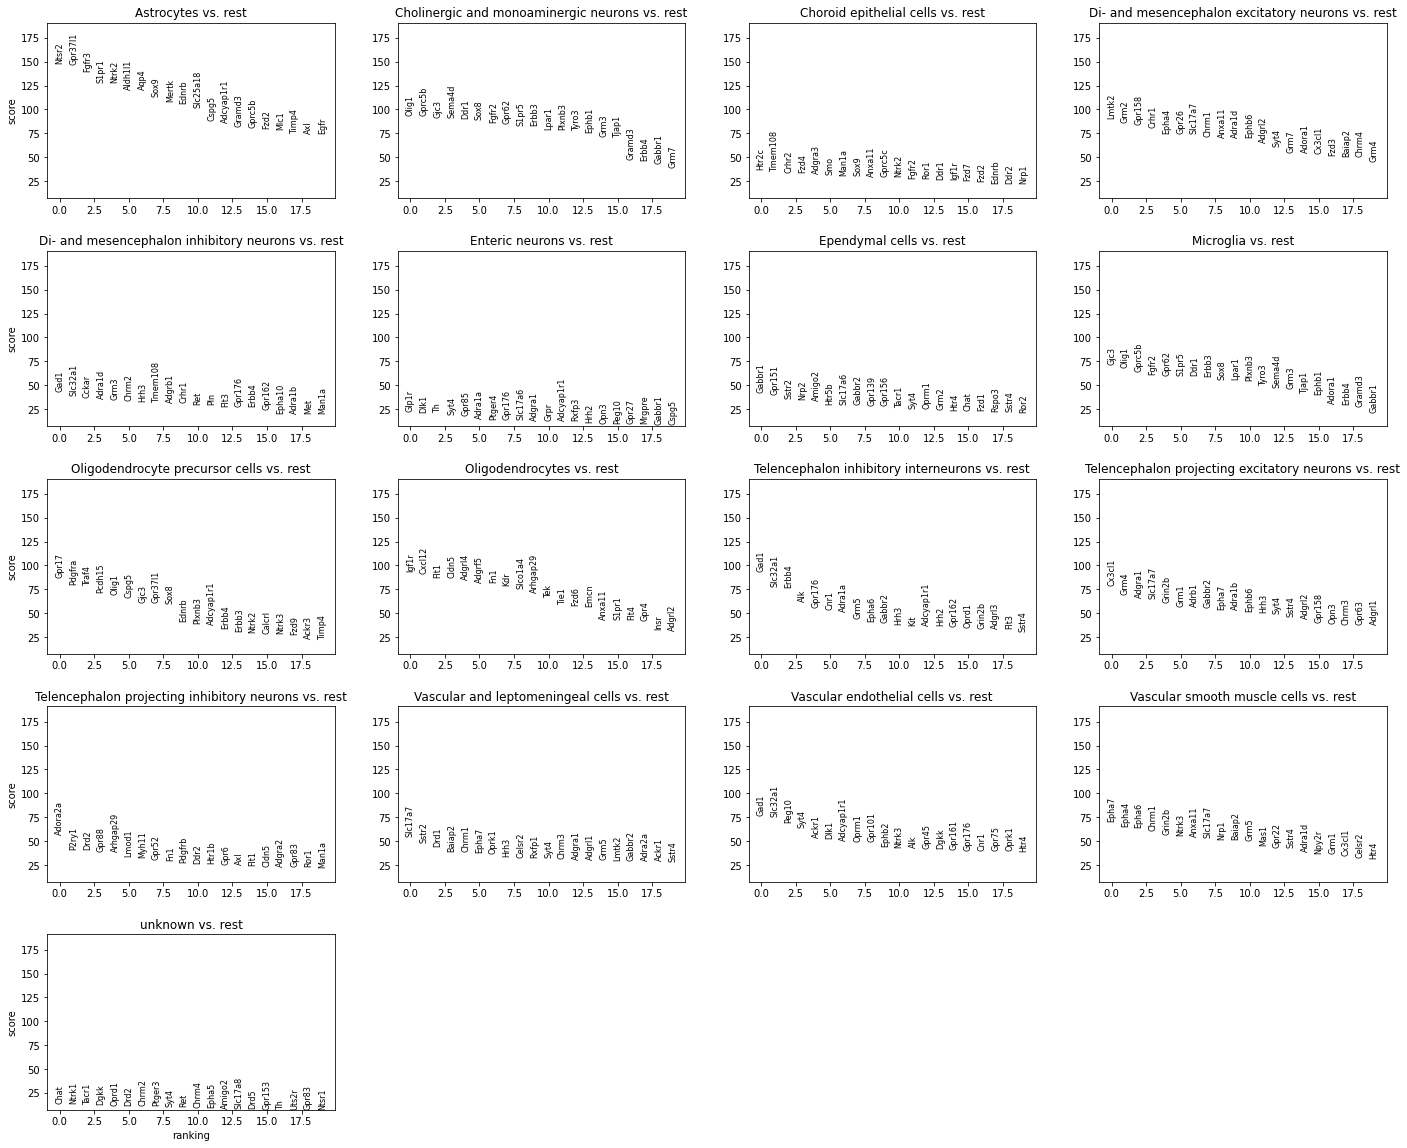

In [114]:
sc.pl.rank_genes_groups(ad_viz_rotated)

In [134]:
import itertools
from scipy.spatial.distance import squareform, pdist

In [ ]:
ad_viz_rotated.X = squareform(pdist(ad_viz_rotated.X)) 

In [ ]:
# plot top 5 genes per group
sc.pl.rank_genes_groups_heatmap(ad_viz_rotated, n_genes=5, show_gene_labels=True)

In [ ]:
sc.pl.rank_genes_groups_dotplot(ad_viz_rotated, n_genes=4)
